In [21]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import warnings
warnings.filterwarnings(action='once')

co.check_python_requirements()
co.test_R_libraries_installation()

In [22]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

In [23]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

In [24]:
adTrain = sc.read_h5ad('./TM_FACS_heart.h5ad')

In [25]:
# adQuery = sc.read_h5ad('./hIPSC_CM_orlova_GSM4443382.h5ad')

In [27]:
# human_to_mouse = pd.read_csv('./human_mouse_genes.csv')

## Here we convert human genes to mouse genes for the following analysis.

In [31]:
# human_genes = list(human_to_mouse.loc[:, 'human'])
# mouse_genes = list(human_to_mouse.loc[:, 'mouse'])

In [41]:
# adQuery_genes = adQuery.var_names.values.tolist()

In [42]:
# for i in range(len(adQuery_genes)):
#     for j in range(len(human_genes)):
#         if adQuery.var_names[i] == human_genes[j]:
#             adQuery_genes[i] = mouse_genes[j]

In [ ]:
# for i in range(len(adQuery_genes)):
#     adQuery_genes[i] = mouse_genes[human_genes.index(adQuery_genes[i])]

In [61]:
# adQuery.var.index = adQuery_genes

In [63]:
# adQuery.var_names.values.tolist().index('Samd11')

26

In [87]:
# adQuery.write_h5ad('./human_to_mouse.h5ad')

In [88]:
# Since we have saved the pre-processed h5ad, we can directly load it here.
adQuery = sc.read_h5ad('./human_to_mouse.h5ad')

In [89]:
genesTrain = adTrain.var_names
genesQuery = adQuery.var_names

In [90]:
cgenes = genesTrain.intersection(genesQuery)

In [91]:
len(cgenes)

14618

In [92]:
adTrain1 = adTrain[:, cgenes]
adQuery = adQuery[:, cgenes].copy()

In [93]:
sc.settings.verbosity = 3 
sc.logging.print_header()

import pySingleCellNet as pySCN

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 louvain==0.7.1 pynndescent==0.5.6


In [94]:
expTrain, expVal = pySCN.splitCommonAnnData(adTrain1, ncells=200, dLevel="cell_ontology_class")

cardiac muscle cell : 
133
endocardial cell : 
165
fibroblast : 
2119
leukocyte : 
523
smooth muscle cell : 
42
endothelial cell : 
1177
myofibroblast cell : 
178


In [95]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 100, nTrees = 1000, nTopGenePairs = 100, dLevel = "cell_ontology_class", stratify=True, limitToHVG=True)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
HVG
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Matrix normalized
There are  702  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 691 top gene pairs

Finished pair transforming the data



In [96]:
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)

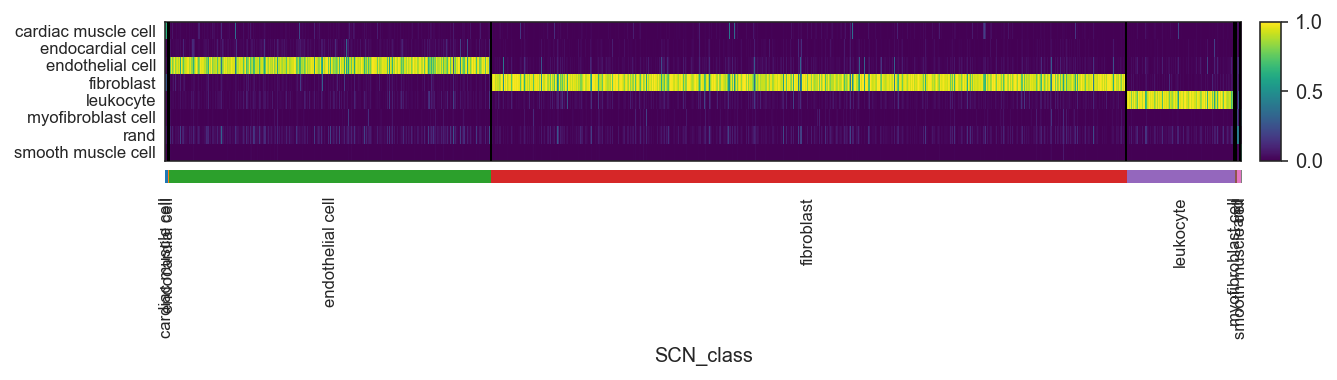

In [97]:
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

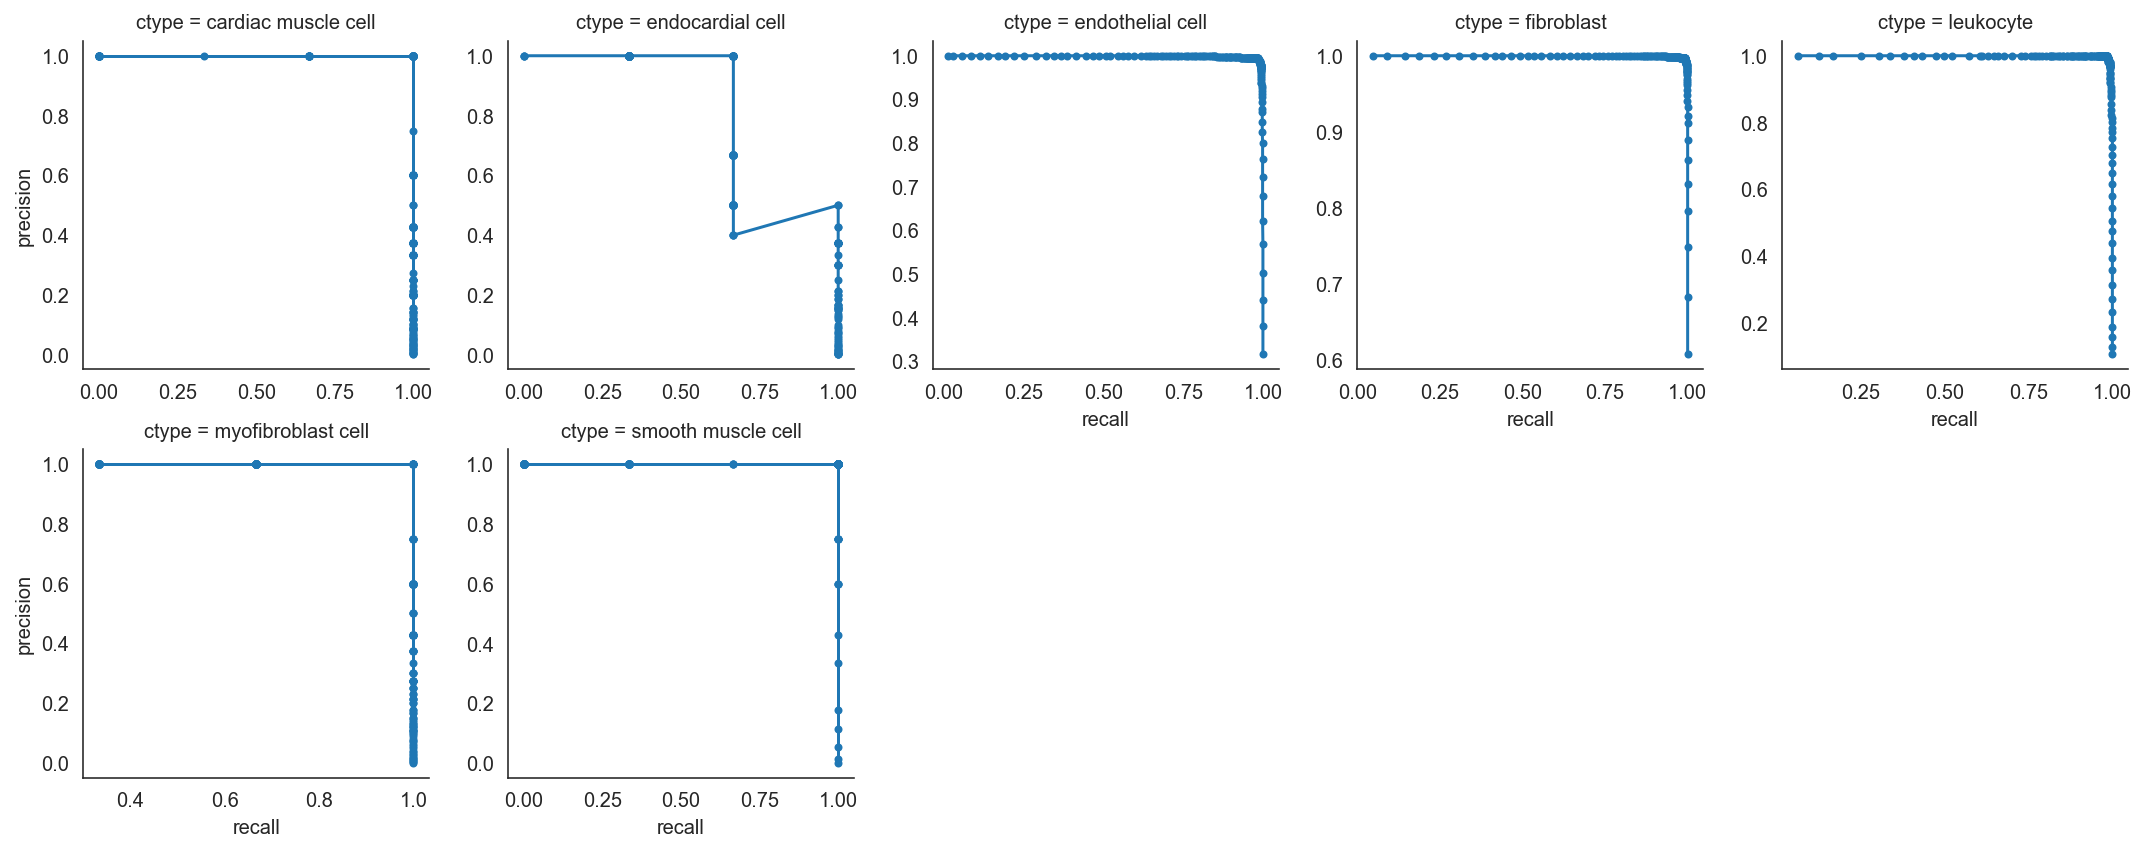

In [98]:
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")

pySCN.plot_PRs(assessment)
plt.show()

In [99]:
adQuery.layers["raw_count"] = adQuery[:, cgenes].X.copy()

In [100]:
adQuery.raw = adQuery[:, cgenes].copy()

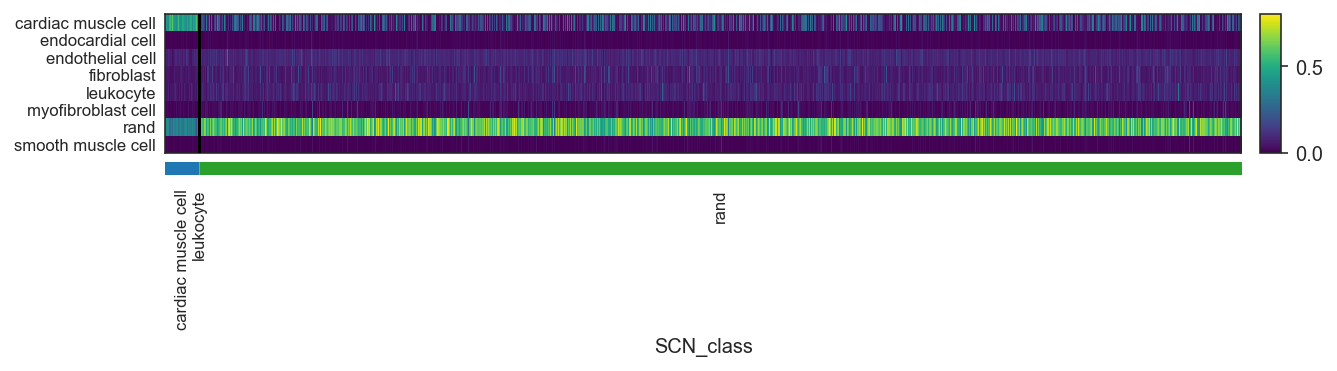

In [101]:
adQstone = pySCN.scn_classify(adQuery, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adQstone, adQstone.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

In [102]:
adQstone[adQstone.obs['SCN_class']=='cardiac muscle cell']

View of AnnData object with n_obs × n_vars = 116 × 8
    obs: 'SCN_class'
    uns: 'SCN_class_colors'

In [104]:
pySCN.add_classRes(adQuery, adQstone)

In [105]:
cardiac_cells = adQuery[adQuery.obs['SCN_class']=='cardiac muscle cell']
# cardiac_cells.write_h5ad('./human_cardiac_cells_raw.h5ad')

filtered out 3941 genes that are detected in less than 5 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:09)


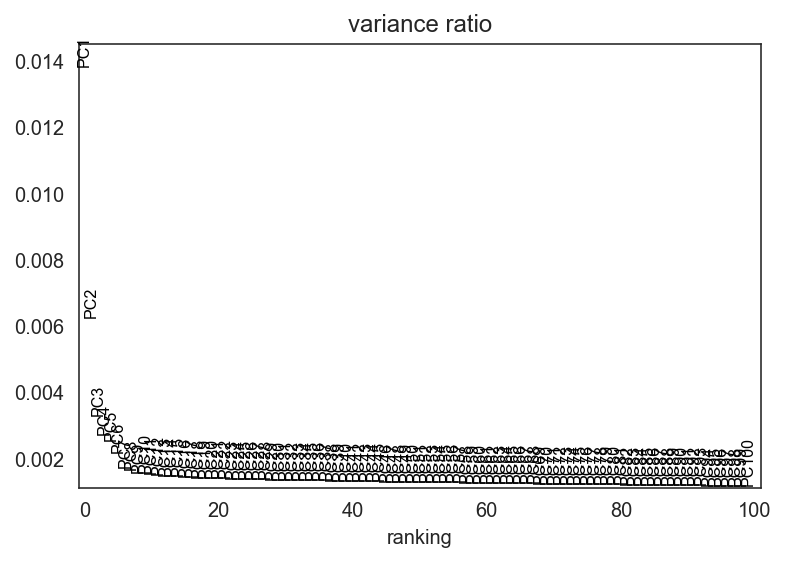

In [106]:
adM1Norm = adQuery.copy()
sc.pp.filter_genes(adM1Norm, min_cells=5)
sc.pp.normalize_per_cell(adM1Norm, counts_per_cell_after=1e4)
sc.pp.log1p(adM1Norm)

sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=4, min_disp=0.5)

adM1Norm.raw = adM1Norm
sc.pp.scale(adM1Norm, max_value=10)
sc.tl.pca(adM1Norm, n_comps=100)

sc.pl.pca_variance_ratio(adM1Norm, 100)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


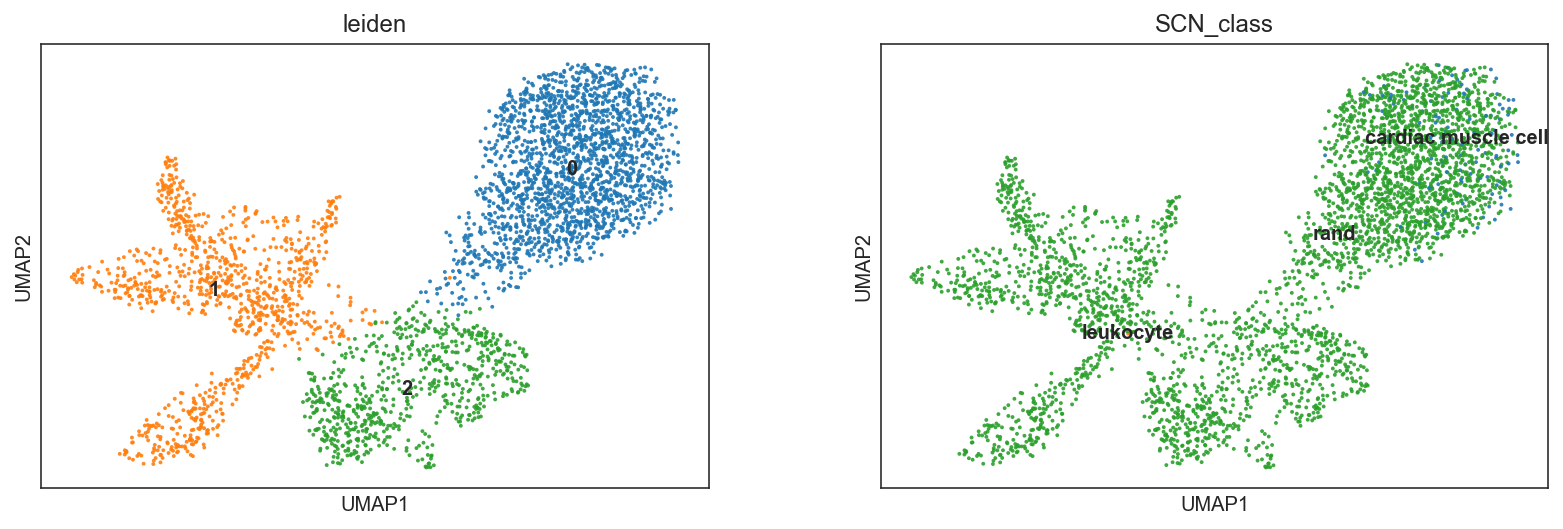

In [107]:
npcs = 20
sc.pp.neighbors(adM1Norm, n_neighbors=10, n_pcs=npcs)
sc.tl.leiden(adM1Norm,.1)
sc.tl.umap(adM1Norm, .5)
sc.pl.umap(adM1Norm, color=["leiden", "SCN_class"], alpha=.9, s=15, legend_loc='on data')

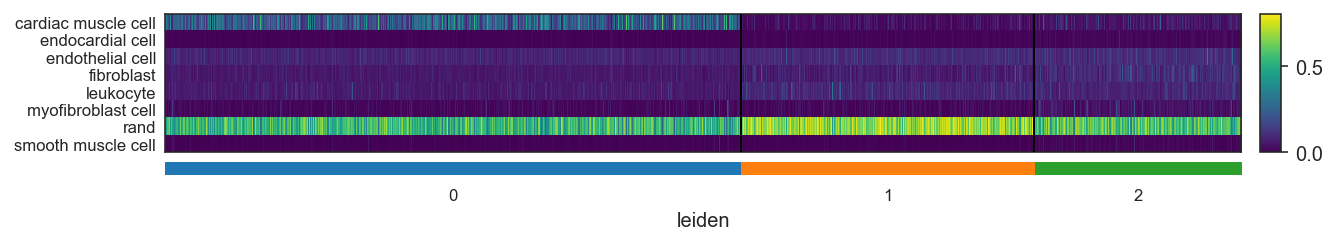

In [108]:
adQstone.obs['leiden'] = adM1Norm.obs['leiden'].copy()
adQstone.uns['leiden_colors'] = adM1Norm.uns['leiden_colors']
ax = sc.pl.heatmap(adQstone, adQstone.var_names.values, groupby='leiden', cmap='viridis', dendrogram=False, swap_axes=True)

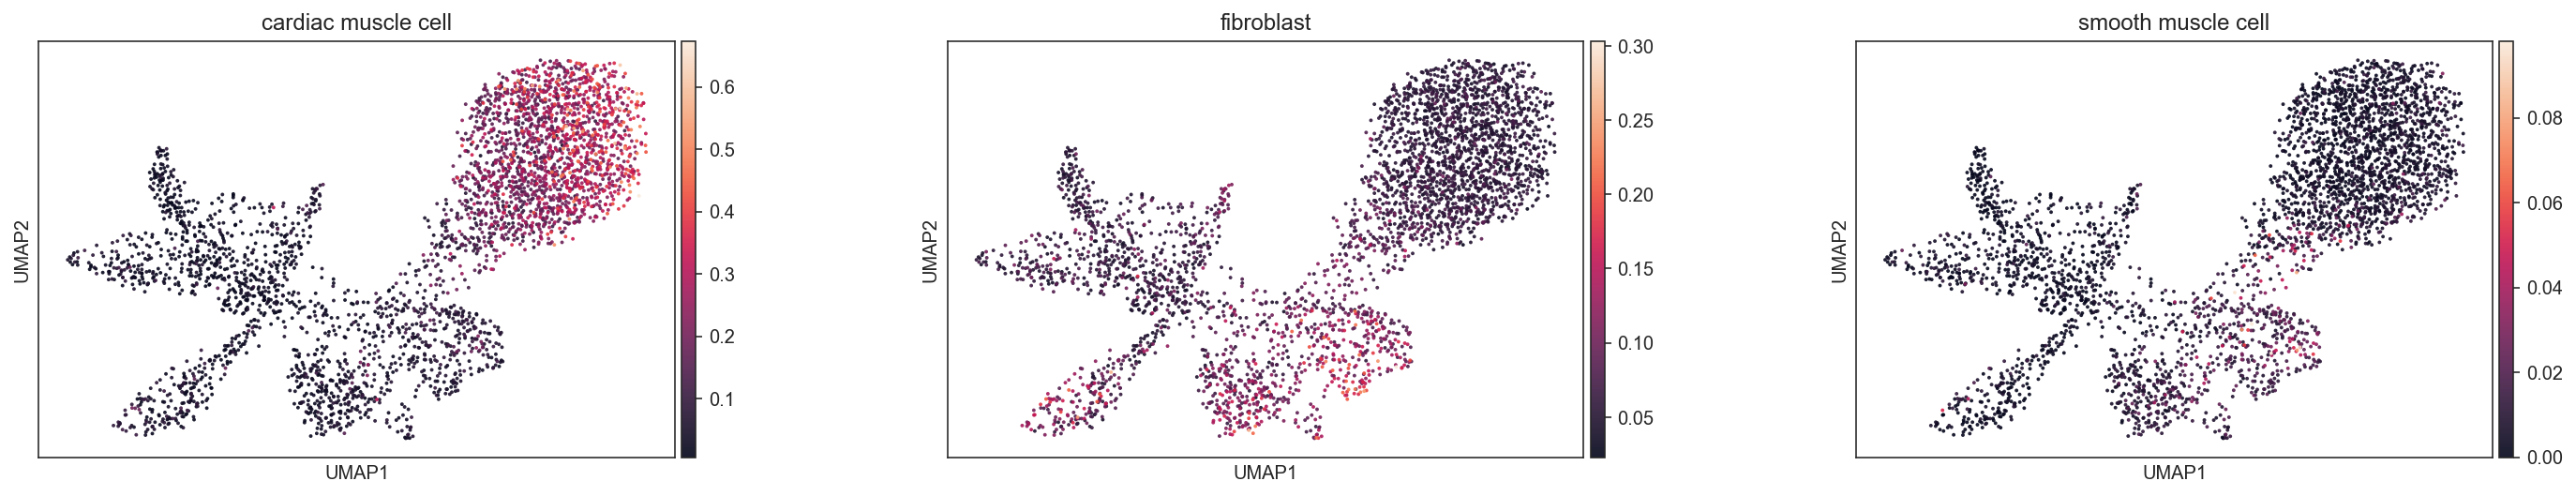

In [109]:
sc.pl.umap(adM1Norm, color=["cardiac muscle cell", "fibroblast", "smooth muscle cell"], alpha=.9, s=15, legend_loc='on data', wspace=.3)

In [110]:
refdata = sc.read_h5ad('./Kannan_perinatal_reference.h5ad')

In [124]:
sc.pp.filter_genes(refdata, min_counts=1)

filtered out 2029 genes that are detected in less than 1 counts


In [125]:
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(refdata, key_n_counts='n_counts_all')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)


In [126]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(refdata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# Subset the genes
refdata = refdata[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(refdata)

extracting highly variable genes
    finished (0:00:01)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [127]:
# keep raw cont data before log transformation
refdata.raw = refdata
refdata.layers["raw_count"] = refdata.raw.X.copy()


# Log transformation and scaling
sc.pp.log1p(refdata)
sc.pp.scale(refdata)

In [128]:
# PCA
sc.tl.pca(refdata, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(refdata, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(refdata)
# Calculate neihbors again based on diffusionmap
sc.pp.neighbors(refdata, n_neighbors=10, use_rep='X_diffmap')

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9901804  0.98334605 0.9761979  0.9743643  0.9656577
     0.95909625 0.9527863  0.9519671  0.94856614 0.9425219  0.93611825
     0.93554527 0.93351644 0.9304151 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [129]:
sc.tl.louvain(refdata, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [130]:
# PAGA graph construction
sc.tl.paga(refdata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


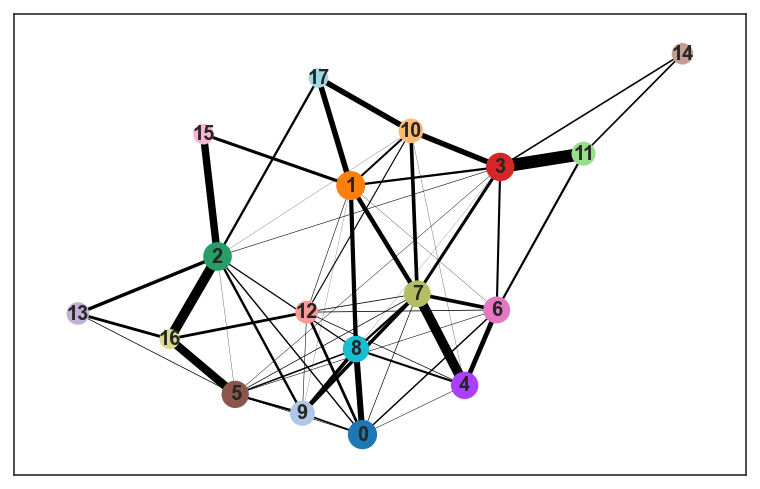

In [131]:
sc.pl.paga(refdata)

In [132]:
sc.tl.draw_graph(refdata, init_pos='paga', random_state=123)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:13)


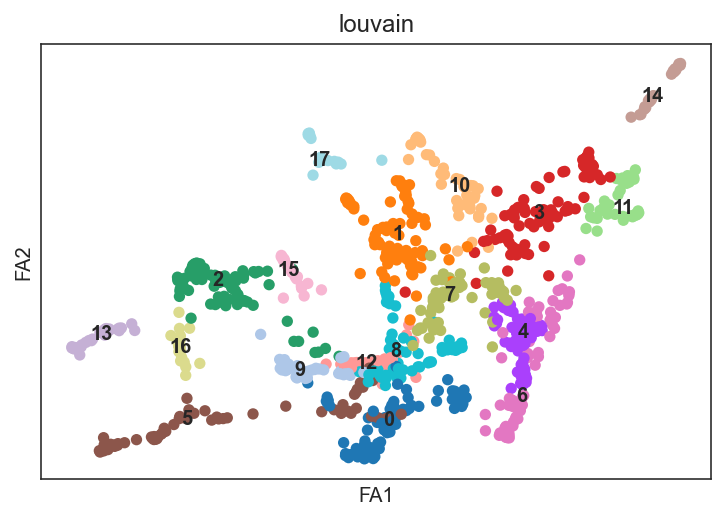

In [133]:
sc.pl.draw_graph(refdata, color='louvain', legend_loc='on data')

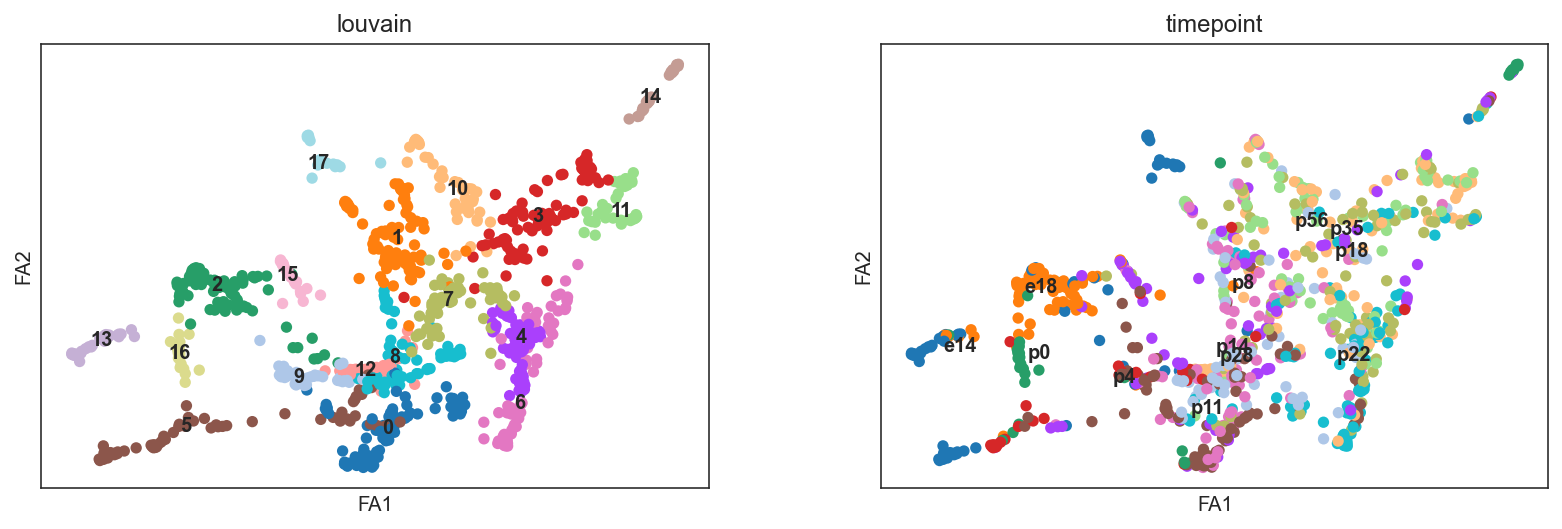

In [134]:
sc.pl.draw_graph(refdata, color=['louvain', 'timepoint'],
                 legend_loc='on data')

In [135]:
# Check current cluster name
cluster_list = refdata.obs.louvain.unique()
cluster_list

['2', '13', '16', '17', '9', ..., '8', '10', '0', '11', '6']
Length: 18
Categories (18, object): ['0', '1', '2', '3', ..., '14', '15', '16', '17']

In [136]:
refdata.obs

i7 cellbarcode  column timepoint  genes   umis  \
AAGAGGCAAAAGTT  AAGAGGCA      AAAGTT       2       e18   3634  13286   
AAGAGGCAATATAG  AAGAGGCA      ATATAG       1       e14   6540  33196   
AAGAGGCAATCAAA  AAGAGGCA      ATCAAA       2       e18   4768  23413   
AAGAGGCAATGAAT  AAGAGGCA      ATGAAT       3        p0   7775  55248   
AAGAGGCACCCACG  AAGAGGCA      CCCACG       1       e14   5524  25256   
...                  ...         ...     ...       ...    ...    ...   
GGACTCCTTCTGCA  GGACTCCT      TCTGCA       4        p4   7533  38004   
GTAGAGGAAAGATT  GTAGAGGA      AAGATT       4        p4   6199  28008   
TAGGCATGTTGAAA  TAGGCATG      TTGAAA       5        p8   4888  21802   
TCCTGAGCCCAACC  TCCTGAGC      CCAACC       5        p8   4642  22618   
TCCTGAGCGGCGTC  TCCTGAGC      GGCGTC       4        p4   6893  42270   

                ERCC_percent   reads  n_counts_all      n_counts louvain  
AAGAGGCAAAAGTT      0.135481   32540       32239.0  11088.229492       2  
AAGAGGCAATATAG      1.159778   74811       72942.0   8915.936523      13  
AAGAGGCAATCAAA      0.119592   57580       56065.0  12060.487305       2  
AAGAGGCAATGAAT      0.642557  128987      127210.0  11886.044922      16  
AAGAGGCACCCACG      1.041337   71429       69976.0   9338.579102      13  
...                      ...     ...           ...           ...     ...  
GGACTCCTTCTGCA      0.902537   95643       92797.0   8247.510742       5  
GTAGAGGAAAGATT      2.038703   66286       64254.0   9110.619141       5  
TAGGCATGTTGAAA      1.165031   63119       61239.0  12004.397461       5  
TCCTGAGCCCAACC      0.353701   77349       76462.0  12680.695312       5  
TCCTGAGCGGCGTC      0.456589  125314      123104.0  12646.735352       5  

[936 rows x 11 columns]

In [137]:
print(f"Cell number is :{refdata.shape[0]}")
print(f"Gene number is :{refdata.shape[1]}")

Cell number is :936
Gene number is :2000


In [138]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

In [139]:
base_GRN.head()

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100050979_100052296   4930430F08Rik            0.0         0.0   
1  chr10_101006922_101007748         SNORA17            0.0         0.0   
2  chr10_101144061_101145000          Mgat4c            0.0         0.0   
3    chr10_10148873_10149183   9130014G24Rik            0.0         0.0   
4    chr10_10149425_10149815   9130014G24Rik            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     1.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1095 columns]

In [140]:
oracle = co.Oracle()

In [141]:
# Show data name in anndata
print("metadata columns :", list(refdata.obs.columns))
print("dimensional reduction: ", list(refdata.obsm.keys()))

metadata columns : ['i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads', 'n_counts_all', 'n_counts', 'louvain']
dimensional reduction:  ['X_pca', 'X_diffmap', 'X_draw_graph_fa']


In [142]:
# In this case, we use the unscaled mRNA count for the input of Oracle object.
refdata.X = refdata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=refdata,
                                   cluster_column_name="louvain",
                                   embedding_name="X_draw_graph_fa")

In [143]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [144]:
refdata.obs["fake_cluster"]="all_one_cluster"
refdata.obs.fake_cluster = refdata.obs.fake_cluster.astype("category")
refdata.uns["fake_cluster_colors"] = ['#1f77b4']

In [145]:
oracle.addTFinfo_dictionary({"E2f2/4":['TP53', 'CCNA1', 'CCNA2', 'CCNE1', 'CCNE2', 'CCND3'], \
                            "ErbB2/4":['MAPK1', 'MAPK3', 'MAPK4', 'MAPK6', 'MAPK7', 'MAPK8', 'MAPK9', 'MAPK10', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPK15', 'AKT1', 'AKT2', 'AKT3'], \
                            "ESRRA":['Gata4', 'Atp5g3', 'Coq7', 'Cox6c', 'Ndufa8', 'Ckmt2', 'Slc25a4'], \
                            "FoxM1":['Igf1', 'p21', 'p27'], \
                            "FoxO1/3":['Igf1', 'p21', 'p27'], \
                            "Gata4":['Cdk2', 'Cdk4', 'Hand2', 'BNP', 'Myh6', 'Cdkn1c'], \
                            "HIF1A":['Mfn1', 'Mfn2', 'Opa1'], \
                            "Isl1":['Fgfs', 'Bmps', 'Hand2'], \
                            "Maf":['Gsta1', 'HMOX1'], \
                            "Mef2":["Myh6"], \
                            "Meis1":["p15", "p16", "p21"], \
                            "NKX2-5":["MIR1-1", 'MIR1-2'], \
                            "Nrf2":["Nfe2l1", 'Gsta1', 'HMOX1'], \
                            "PPARGC1A":["ESRRA", "Atp5mc3", "Coq7", "Cox6c", "Ndufa8", "Ckmt2", "Slc25a4"], \
                            "PPARA":["ESRRA", "Atp5mc3", "Coq7", "Cox6c", "Ndufa8", "Ckmt2", "Slc25a4"], \
                            "Tbx20":["Ccna2", "Cdde", "Mycn", "Erbb2", "Cdkn1a", "Meis1", "Btg2"], \
                            "Tbx5":["Cdk2", "Cdk4", "Nppa", "Gja5", "Scn5a", "Myh6"], \
                            "Yap1":["SMAD1", "SMAD2", "SMAD3", "SMAD4", "SMAD5", "SMAD6", "SMAD7", "SMAD9", "Tcf4", "Prkn"]})

In [146]:
oracle.perform_PCA()
n_comps = 50
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

Auto-selected k is :23


In [147]:
def getList(dict):
    return list(dict.keys())

TFlist = getList(oracle.TFdict)

In [148]:
reflist = list(refdata.var_names)

In [149]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

insec_list = intersection(TFlist, reflist)

In [150]:
refdata.layers['imputed_count'] = refdata.X 

In [151]:
oracle.import_anndata_as_raw_count(adata=refdata,
                                   cluster_column_name="fake_cluster", #bad
#                                    cluster_column_name="louvain_annot", #good
                                   embedding_name="X_draw_graph_fa")

In [152]:
oracle._process_TFdict_metadata()

In [153]:
warnings.filterwarnings('ignore') #Otherwise, np.int nightmare
links = oracle.get_links(cluster_name_for_GRN_unit="fake_cluster", alpha=10,
                         verbose_level=10, model_method="bayesian_ridge")

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/1311 [00:00<?, ?it/s]

In [154]:
links.links_dict["all_one_cluster"].head()

source         target  coef_mean  coef_abs  coef_variance         p  \
0  Snai1  0610040J01Rik  -0.000061  0.000061       0.000023  0.989888   
1    Id4  0610040J01Rik  -0.000065  0.000065       0.000023  0.989200   
2   Klf5  0610040J01Rik  -0.000097  0.000097       0.000023  0.983932   
3   Arnt  0610040J01Rik  -0.000124  0.000124       0.000023  0.979526   
4   Rxra  0610040J01Rik  -0.000246  0.000246       0.000023  0.959306   

      -logp  
0  0.010164  
1  0.010859  
2  0.016199  
3  0.020687  
4  0.041545

In [155]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 326 genes


In [156]:
links.get_network_score()
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  \
1700020N01Rik           1               0.002755          1   
1700066J03Rik           1               0.002755          1   
1700082M22Rik           1               0.002755          1   
1810019D21Rik           2               0.005510          2   
1810043G02Rik           1               0.002755          1   

               degree_centrality_in  degree_out  degree_centrality_out  \
1700020N01Rik              0.002755           0                    0.0   
1700066J03Rik              0.002755           0                    0.0   
1700082M22Rik              0.002755           0                    0.0   
1810019D21Rik              0.005510           0                    0.0   
1810043G02Rik              0.002755           0                    0.0   

               betweenness_centrality  eigenvector_centrality          cluster  
1700020N01Rik                     0.0            3.502893e-07  all_one_cluster  
1700066J03Rik                     0.0            4.034743e-07  all_one_cluster  
1700082M22Rik                     0.0            8.621945e-06  all_one_cluster  
1810019D21Rik                     0.0            1.410036e-05  all_one_cluster  
1810043G02Rik                     0.0            2.089842e-05  all_one_cluster

In [168]:
humandata = sc.read_h5ad('./human_to_mouse.h5ad')

In [169]:
humandata.obs["fake_cluster"]="all_one_cluster"
humandata.obs.fake_cluster = humandata.obs.fake_cluster.astype("category")
humandata.uns["fake_cluster_colors"] = ['#1f77b4']

In [170]:
# keep raw cont data before log transformation
humandata.raw = humandata
humandata.layers["raw_count"] = humandata.raw.X.copy()


# Log transformation and scaling
sc.pp.log1p(humandata)
sc.pp.scale(humandata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [171]:
# PCA
sc.tl.pca(humandata, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(humandata, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(humandata)
# Calculate neihbors again based on diffusionmap
sc.pp.neighbors(humandata, n_neighbors=10, use_rep='X_diffmap')

computing PCA
    with n_comps=50
    finished (0:00:19)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99852383 0.9950091  0.99381834 0.99245226 0.99123734
     0.98986757 0.98923135 0.98673546 0.98559415 0.9837008  0.98326886
     0.9828486  0.98173034 0.9793644 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [172]:
sc.tl.louvain(humandata, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


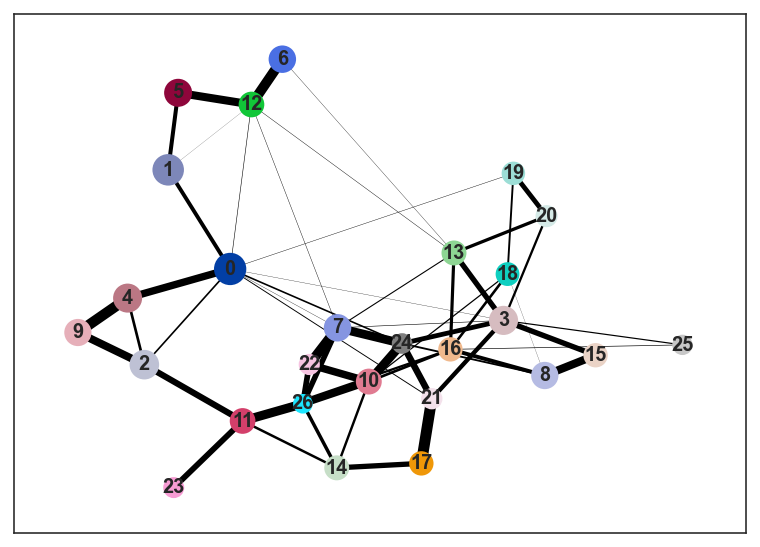

In [173]:
# PAGA graph construction
sc.tl.paga(humandata, groups='louvain')
plt.rcParams["figure.figsize"] = [6, 4.5]
sc.pl.paga(humandata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:27)


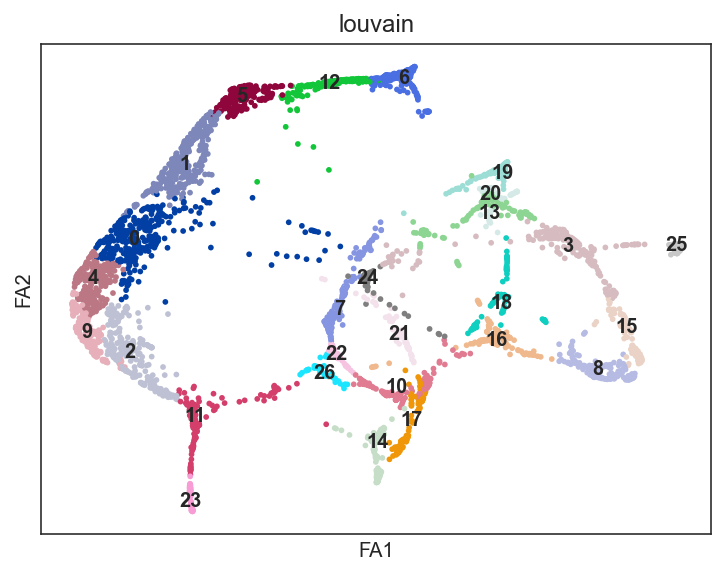

In [174]:
sc.tl.draw_graph(humandata, init_pos='paga', random_state=123)
sc.pl.draw_graph(humandata, color='louvain', legend_loc='on data')

In [175]:
humandata.layers['imputed_count'] = humandata.X
oracle.adata = humandata

In [176]:
oracle._process_TFdict_metadata()

In [177]:
links.links_dict["all_one_cluster"].head()

source         target  coef_mean  coef_abs  coef_variance         p  \
0  Snai1  0610040J01Rik  -0.000061  0.000061       0.000023  0.989888   
1    Id4  0610040J01Rik  -0.000065  0.000065       0.000023  0.989200   
2   Klf5  0610040J01Rik  -0.000097  0.000097       0.000023  0.983932   
3   Arnt  0610040J01Rik  -0.000124  0.000124       0.000023  0.979526   
4   Rxra  0610040J01Rik  -0.000246  0.000246       0.000023  0.959306   

      -logp  
0  0.010164  
1  0.010859  
2  0.016199  
3  0.020687  
4  0.041545

In [178]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(GRN_unit = "whole", alpha=1)

  0%|          | 0/33694 [00:00<?, ?it/s]

genes_in_gem: 33694
models made for 13172 genes


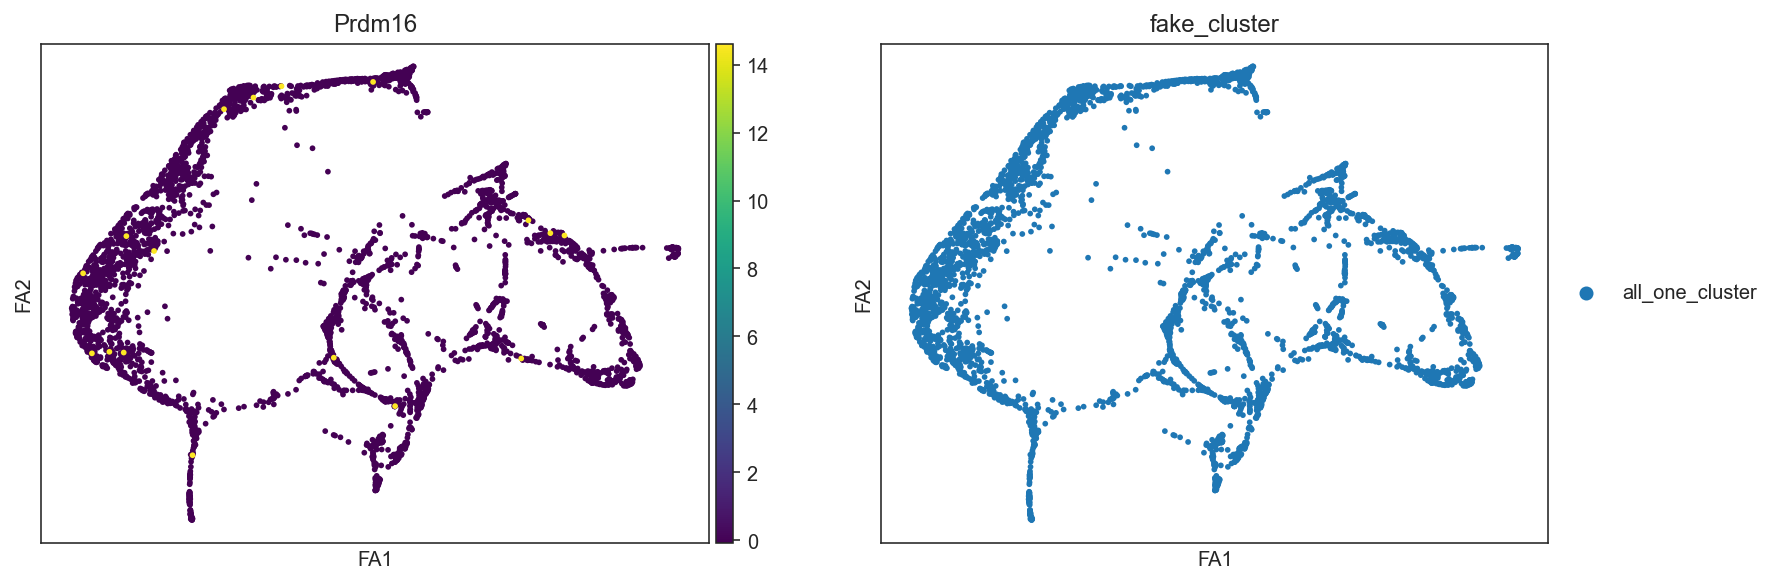

In [179]:
# Check gene expression
goi = "Prdm16"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

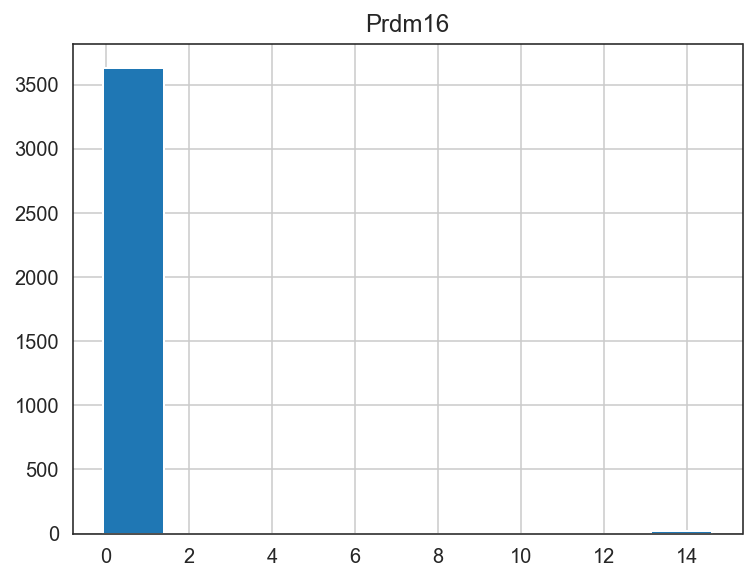

In [180]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [181]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [183]:
oracle.adata.layers['delta_X'] = oracle.adata.layers['delta_X'].astype('float64')

In [184]:
oracle.adata.layers['imputed_count'] = oracle.adata.layers['imputed_count'].astype('float64')

In [185]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

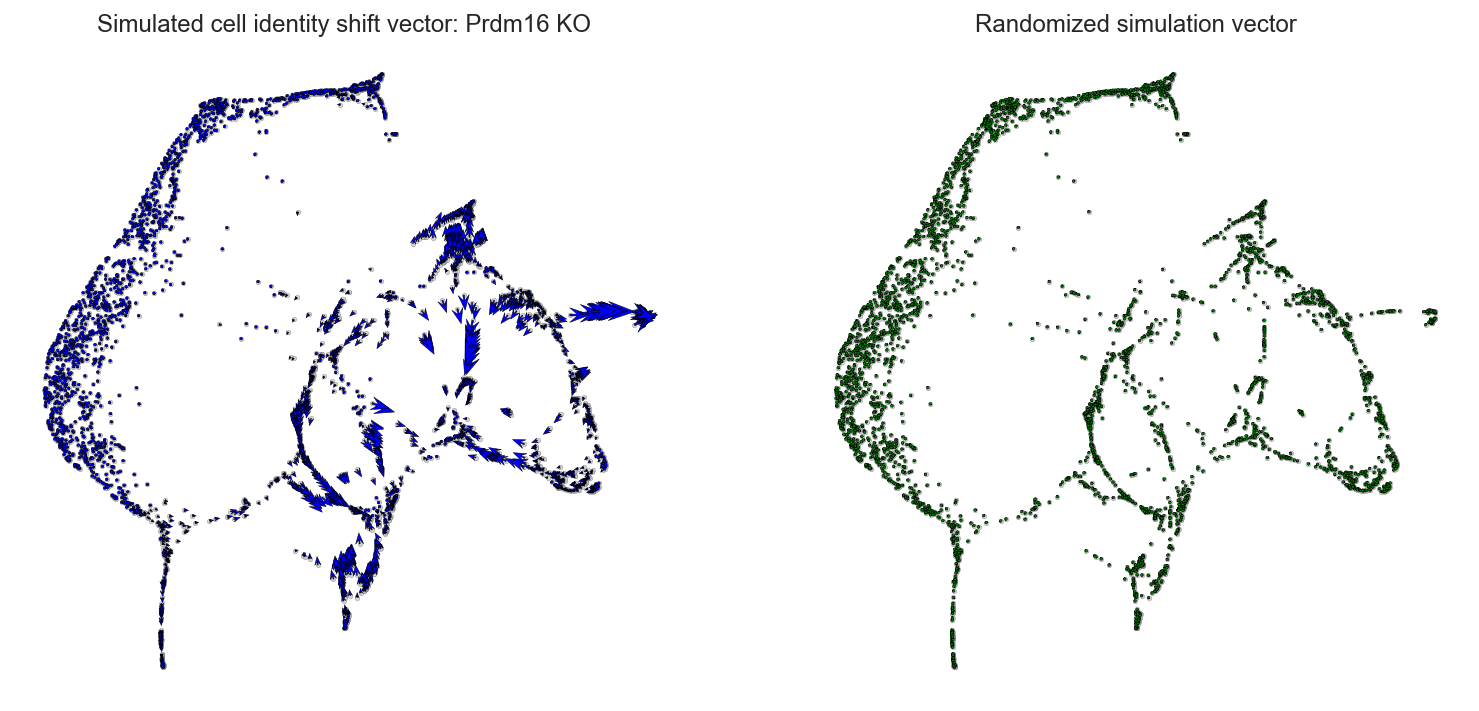

In [186]:
ig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0], color=['blue'])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1], color=['green'])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [187]:
# n_grid = 40 is a good starting value.
n_grid = 50
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

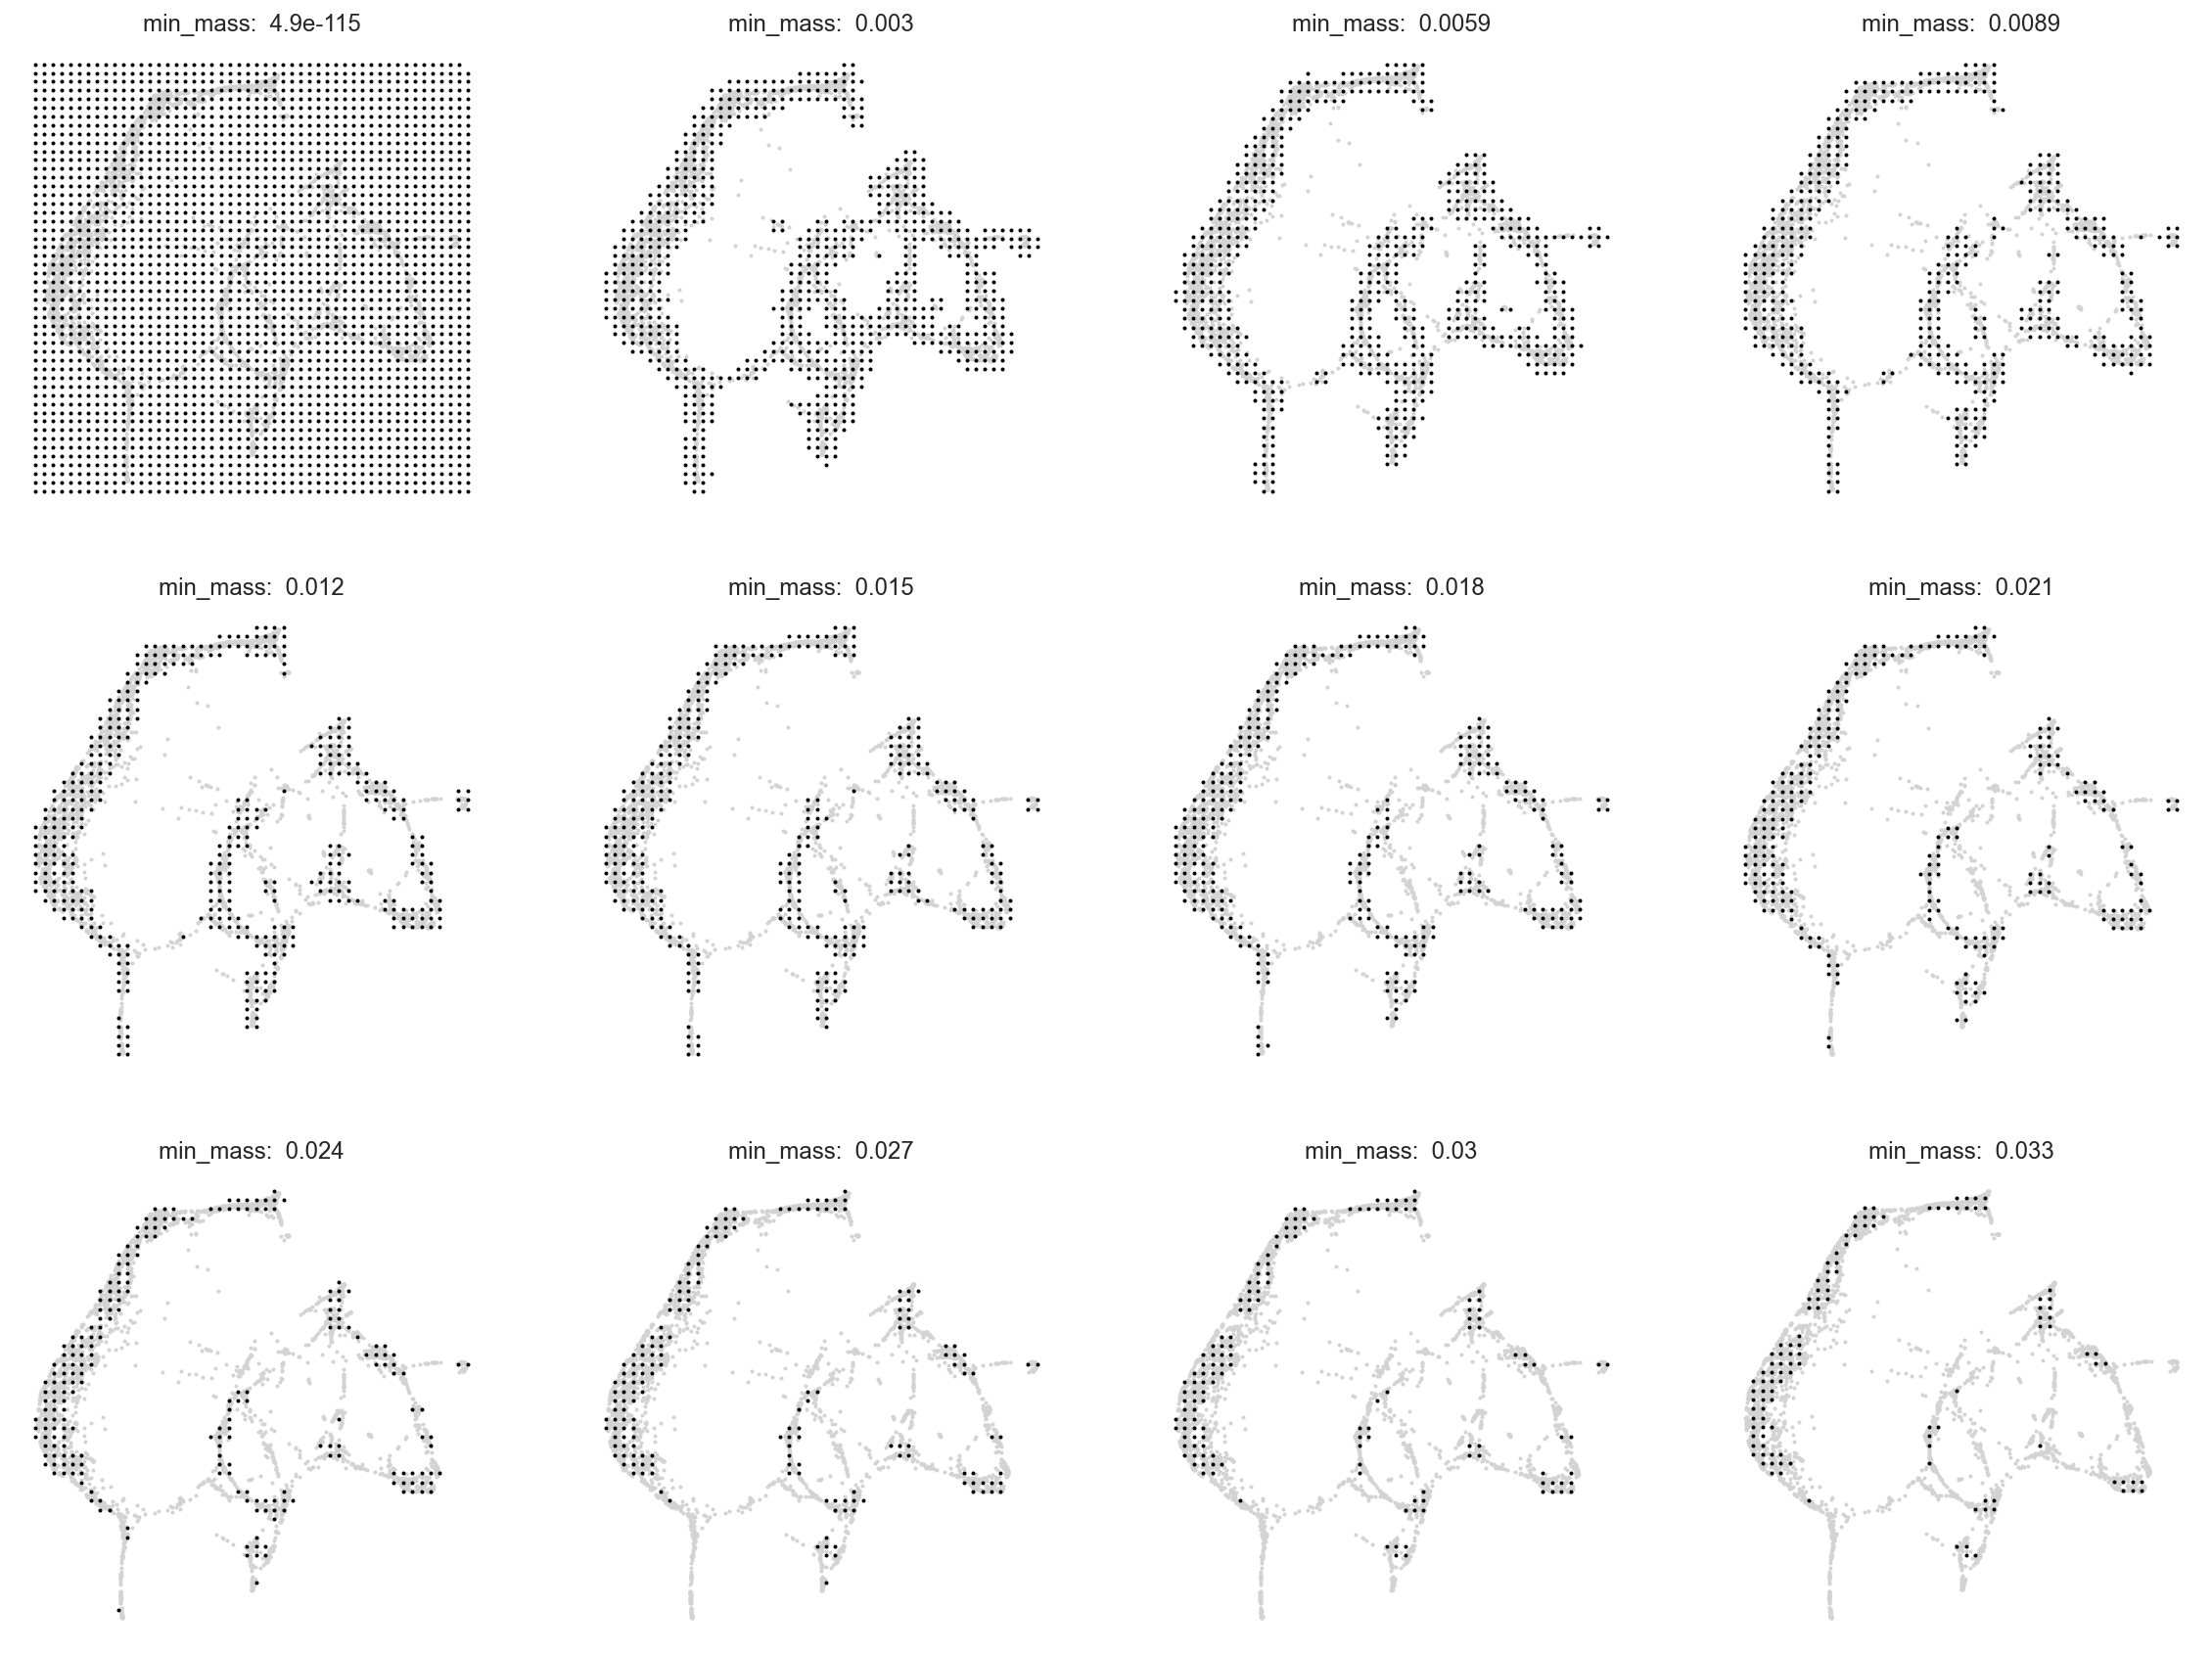

In [188]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

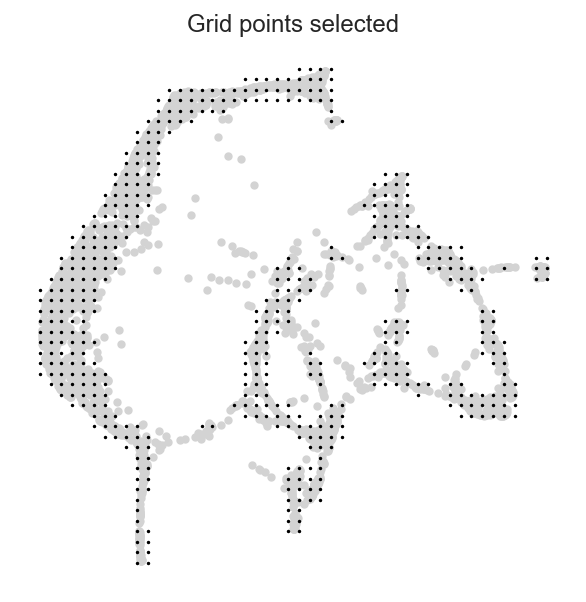

In [189]:
min_mass = 0.01
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

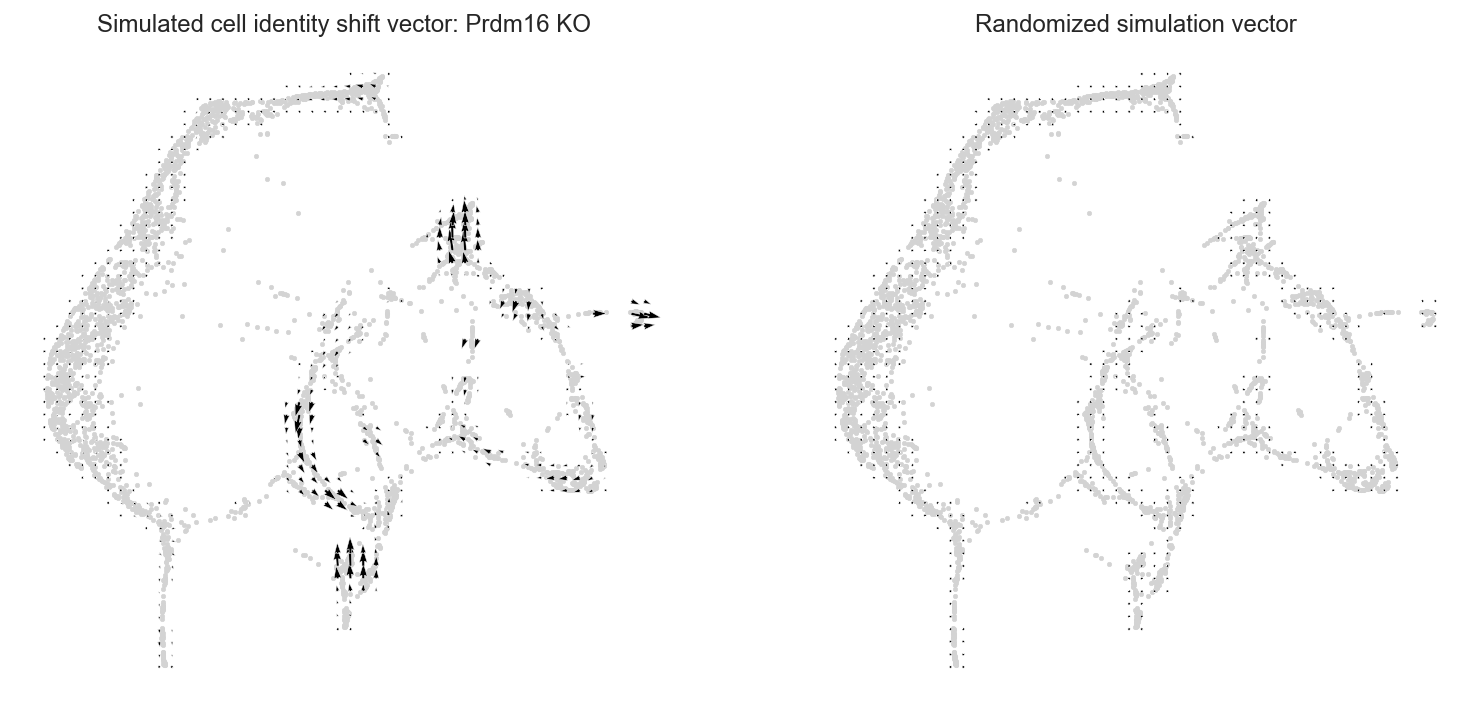

In [190]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [191]:
oracle.colorandum = oracle.colorandum[0]

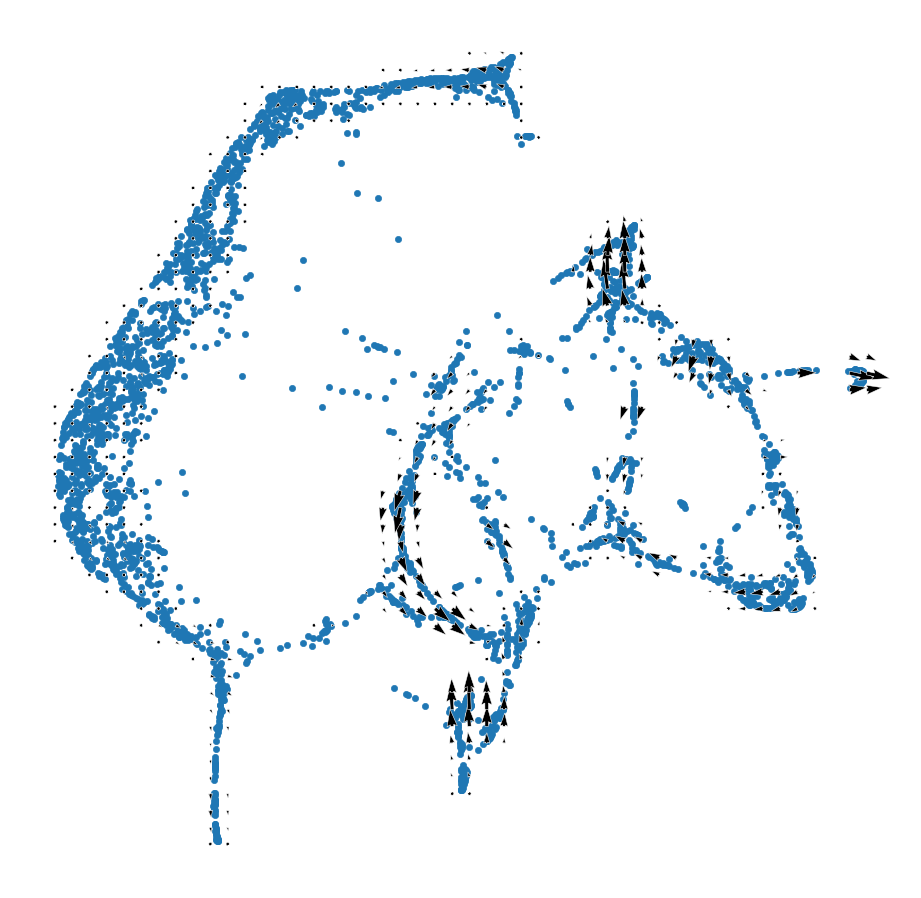

In [192]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [193]:
oracle.adata.uns['iroot'] = np.flatnonzero(oracle.adata.obs['fake_cluster']  == 'all_one_cluster')[0]

In [194]:
sc.tl.dpt(oracle.adata, n_branchings=1)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:01)


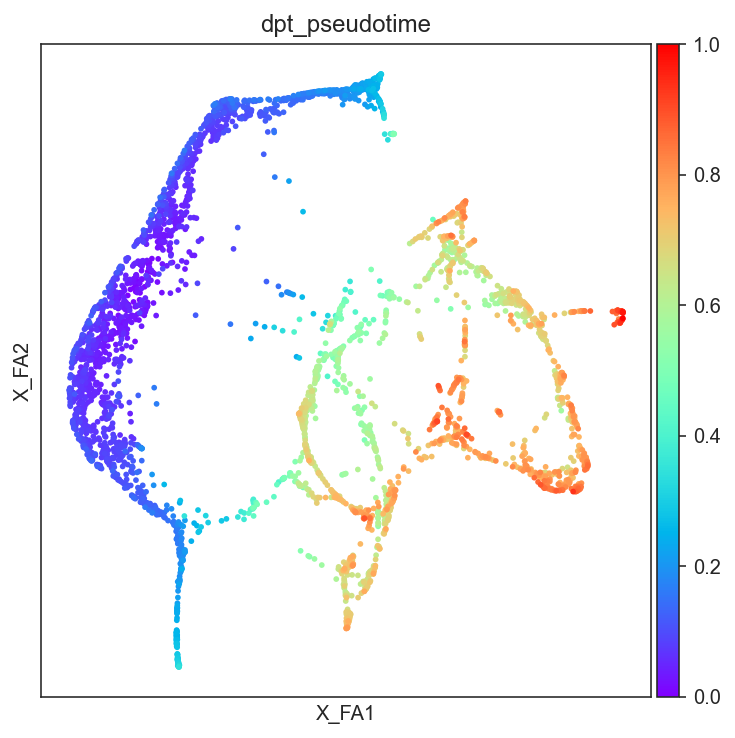

In [195]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["dpt_pseudotime"])

In [196]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="dpt_pseudotime")

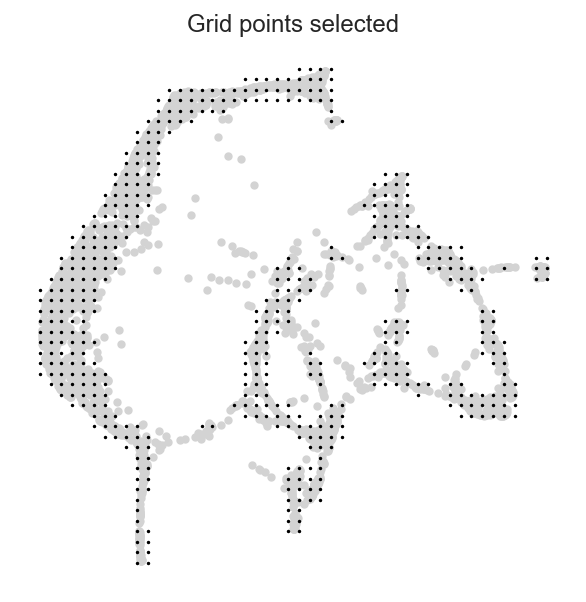

In [197]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

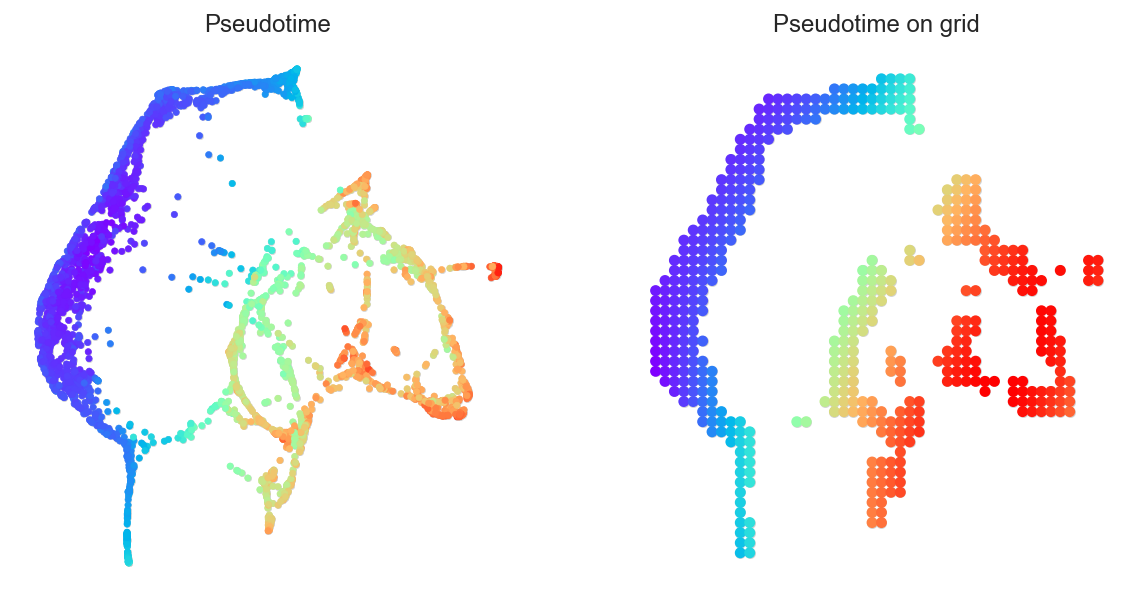

In [198]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

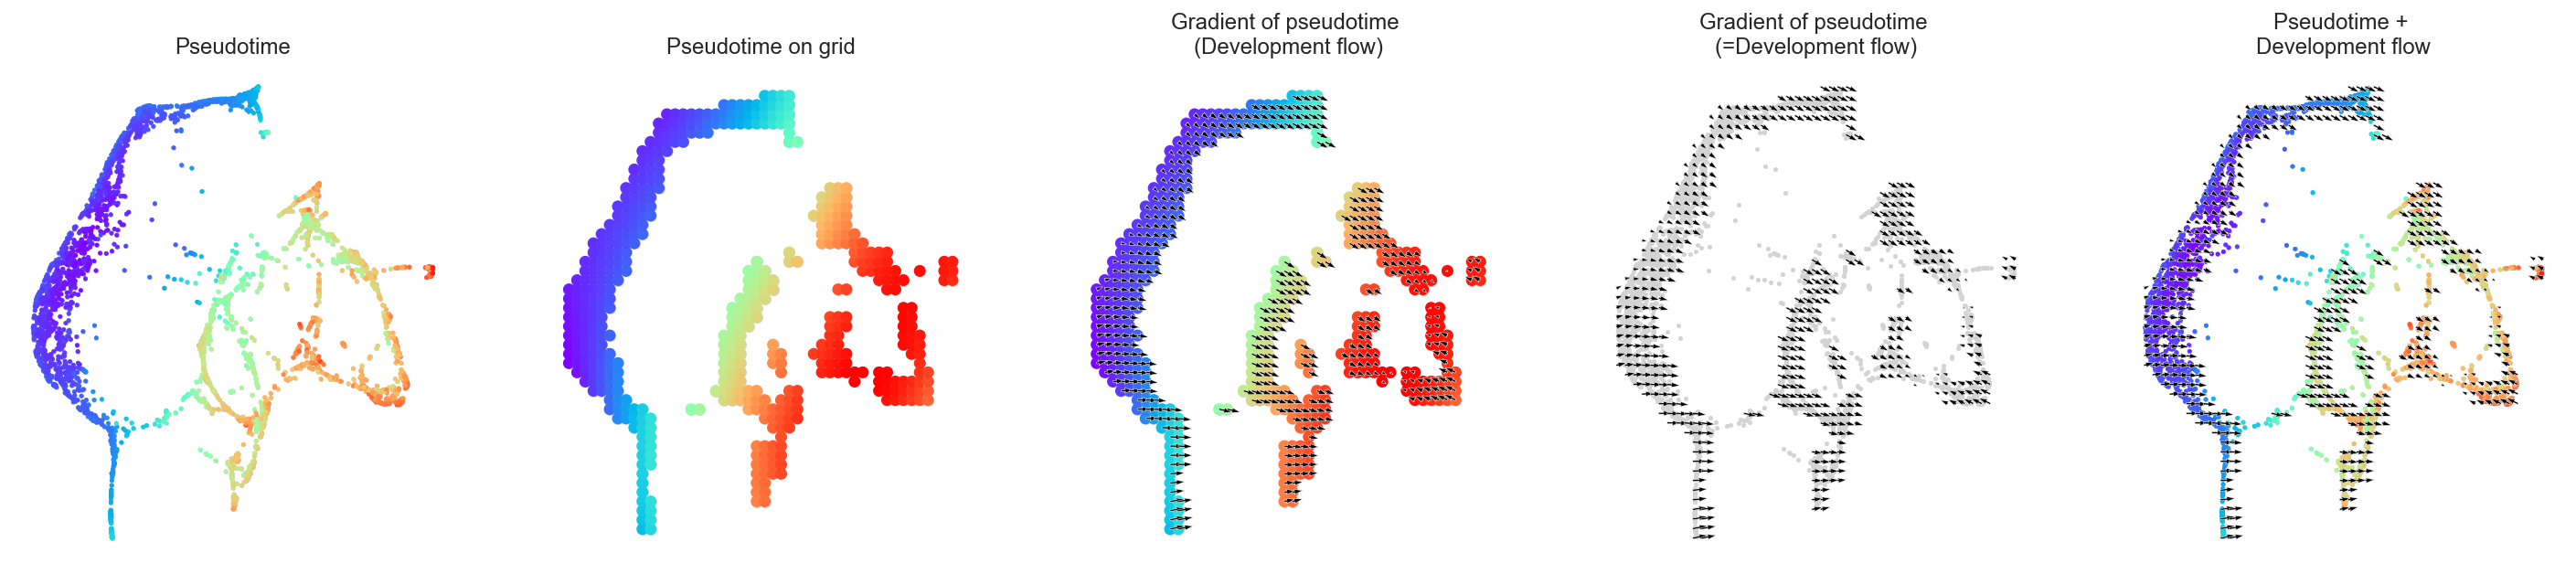

In [199]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

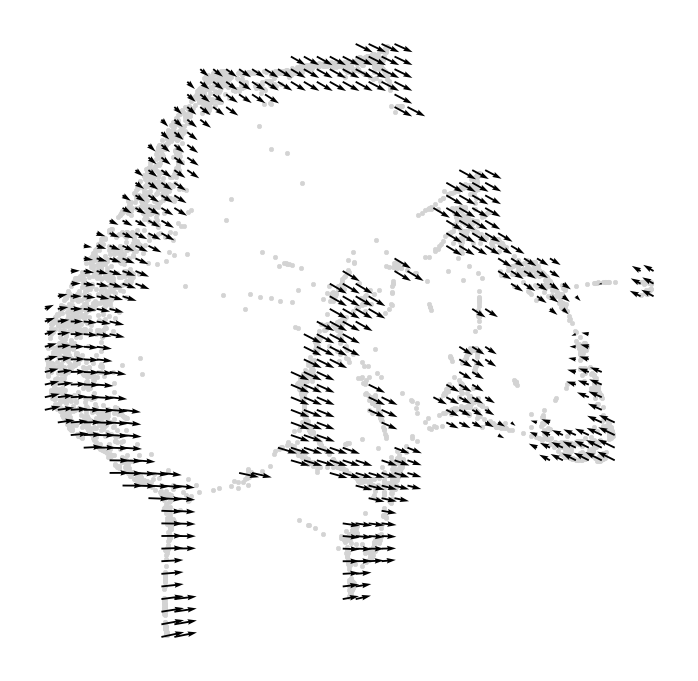

In [200]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [201]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

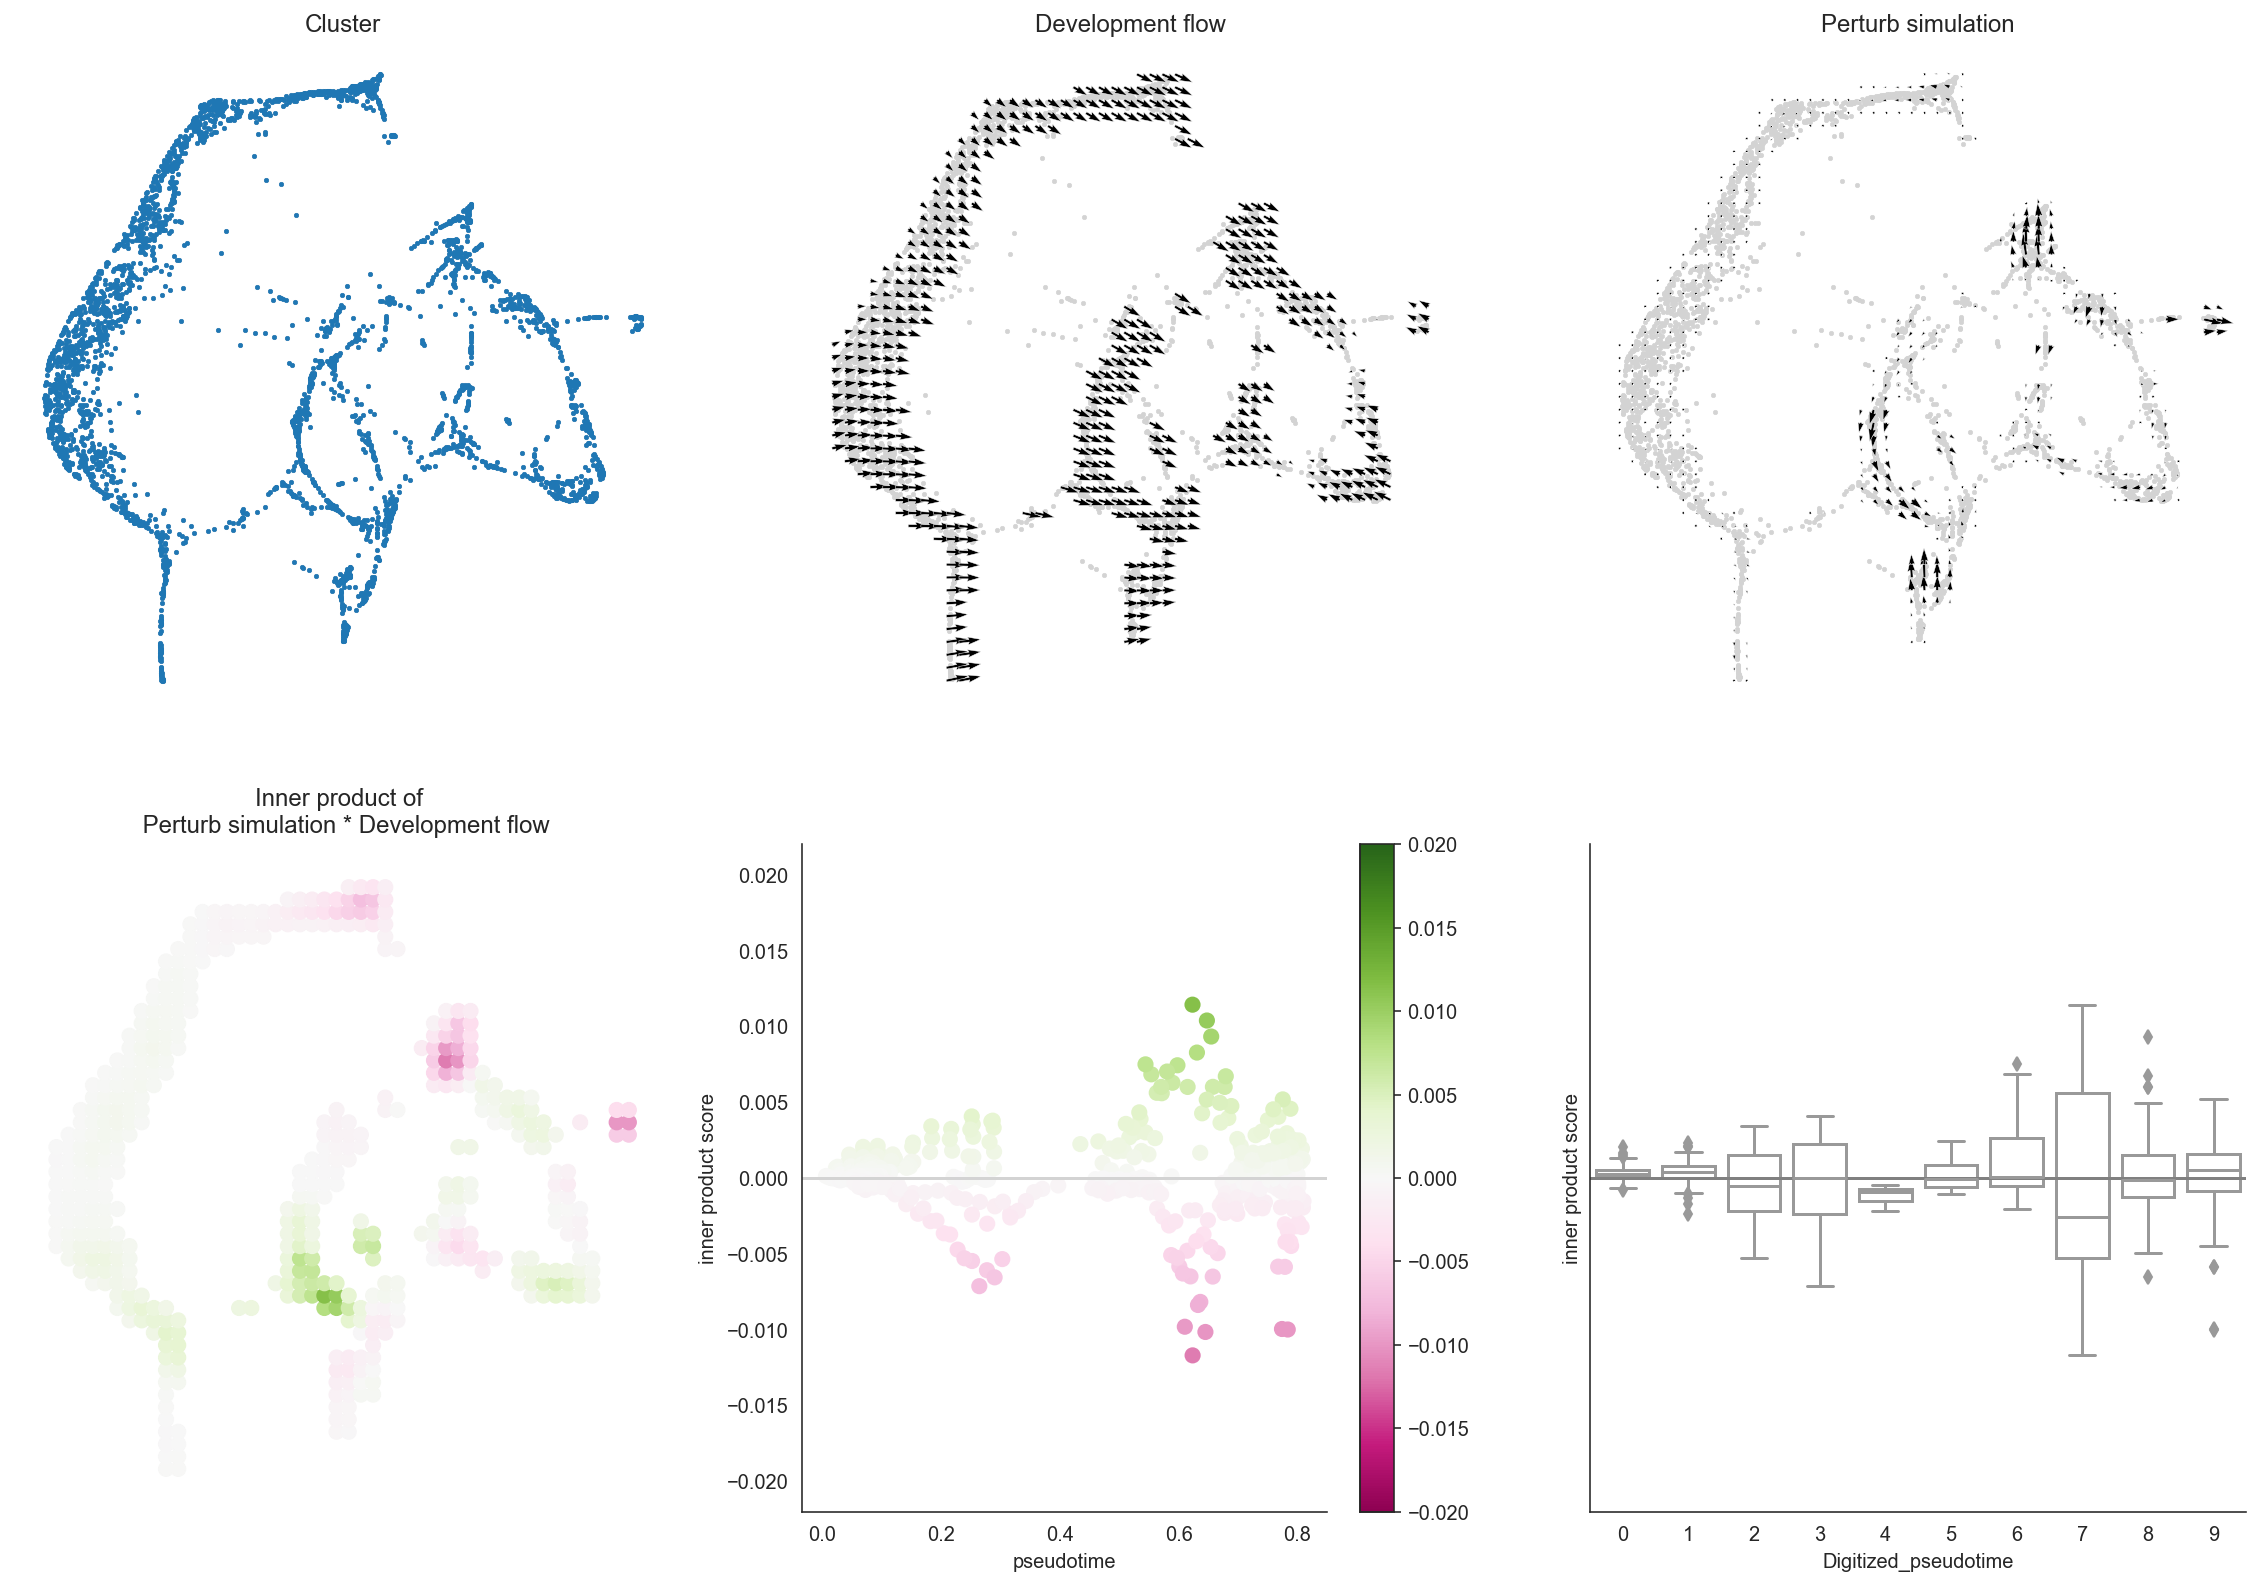

In [202]:
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=0.02)

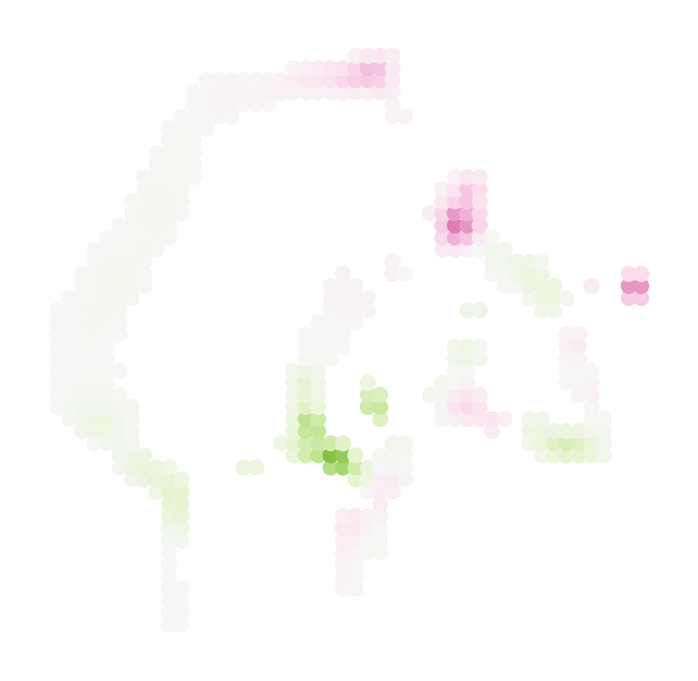

In [203]:
# Show perturbation scores
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.02, s=50, ax=ax)

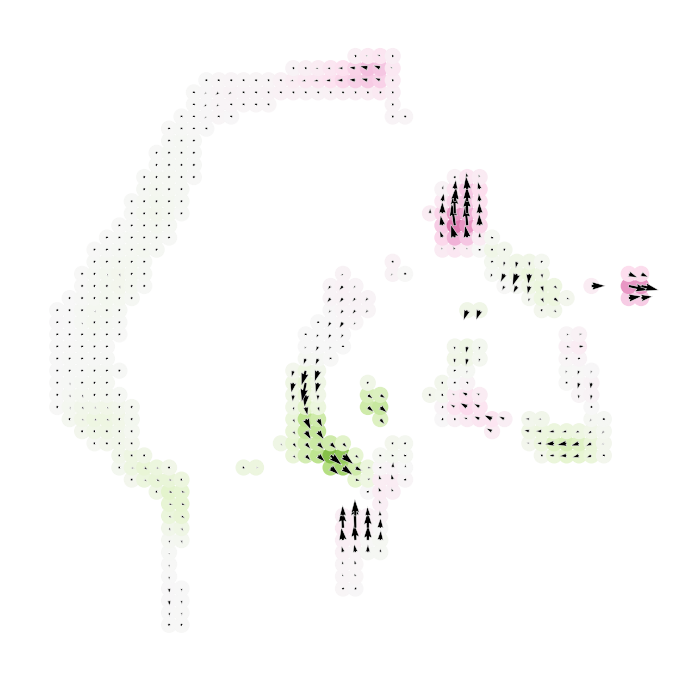

In [204]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.02, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

In [205]:
def rank_TF_usefulness(gene_list):
    " Rank the usefulness of TFs by the average inner product of perturb simulation * development flow"
    
    inner_product_scores = []
    
    for goi in gene_list:
        
        # Enter perturbation conditions to simulate signal propagation after the perturbation.
        oracle.simulate_shift(perturb_condition={goi: 0.0},
                              n_propagation=3)
        
        oracle.adata.layers['delta_X'] = oracle.adata.layers['delta_X'].astype('float64')
        oracle.adata.layers['imputed_count'] = oracle.adata.layers['imputed_count'].astype('float64')
        
        # Get transition probability
        oracle.estimate_transition_prob(n_neighbors=200,
                                        knn_random=True,
                                        sampled_fraction=1)

        # Calculate embedding
        oracle.calculate_embedding_shift(sigma_corr=0.05)
        scale = 25

        # n_grid = 40 is a good starting value.
        n_grid = 50
        oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

        min_mass = 0.01
        oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

        cale_simulation = 0.5

        oracle.adata.uns['iroot'] = np.flatnonzero(oracle.adata.obs['fake_cluster']  == 'all_one_cluster')[0]
        sc.tl.dpt(oracle.adata, n_branchings=1)


        from celloracle.applications import Gradient_calculator
        # Instantiate Gradient calculator object
        gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="dpt_pseudotime")

        gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
        gradient.calculate_mass_filter(min_mass=min_mass)

        gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3})

        # Calculate graddient
        gradient.calculate_gradient()
        scale_dev = 40

        from celloracle.applications import Oracle_development_module
        # Make Oracle_development_module to compare two vector field
        dev = Oracle_development_module()

        # Load development flow
        dev.load_differentiation_reference_data(gradient_object=gradient)

        # Load simulation result
        dev.load_perturb_simulation_data(oracle_object=oracle)


        # Calculate inner produc scores
        dev.calculate_inner_product()
        dev.calculate_digitized_ip(n_bins=10)

        inner_product_score = dev.inner_product.mean(axis=-1)
        inner_product_scores.append(inner_product_score)
        
    ranked_gene_list = [goi for _, goi in sorted(zip(inner_product_scores, gene_list))]
    
    return ranked_gene_list, inner_product_scores

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:01)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:01)


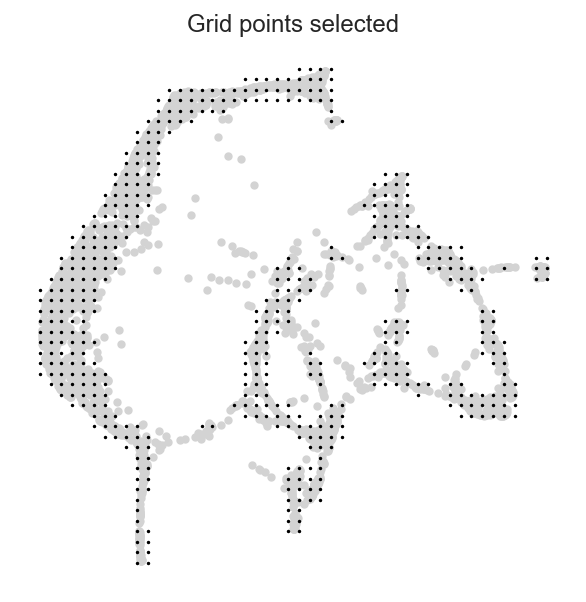

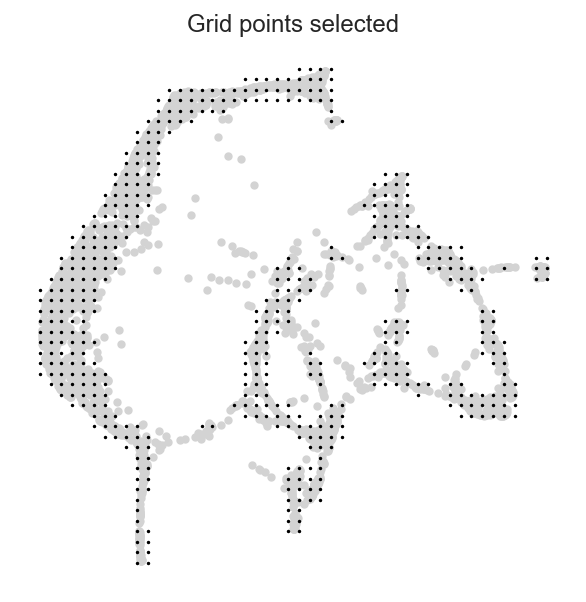

In [207]:
gene_list = ['Foxo1', 'Prdm1']
ranked_gene_list, inner_product_scores = rank_TF_usefulness(gene_list)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:01)


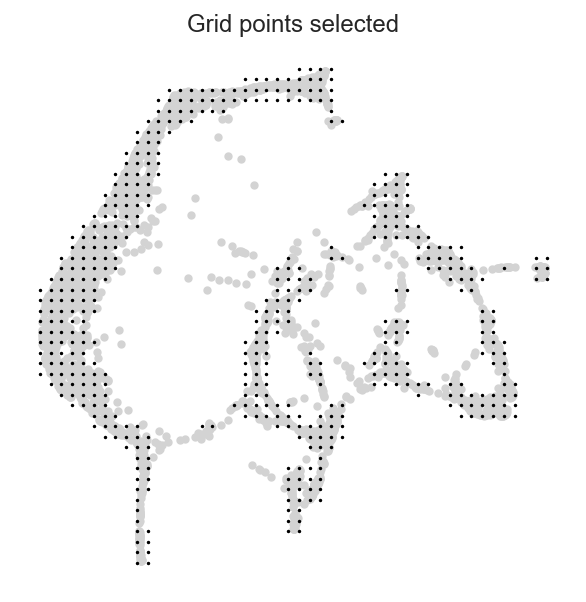

In [210]:
_, inner_product_score_supp = rank_TF_usefulness(['Cux1'])

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:01)


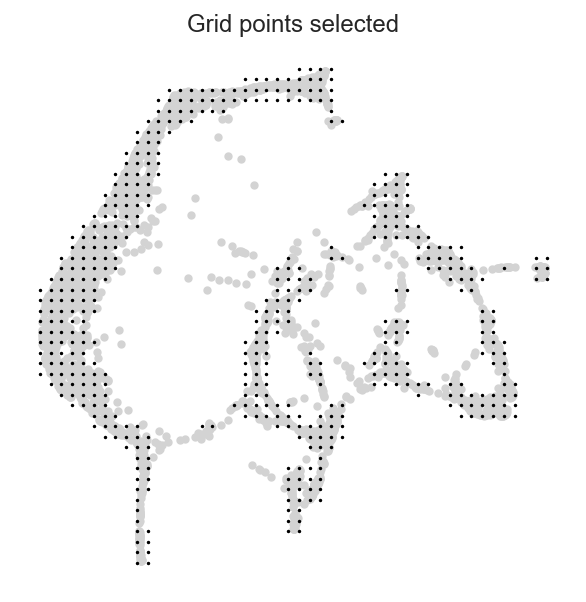

In [211]:
_, inner_product_score_supp_1 = rank_TF_usefulness(['Ctcf'])

In [218]:
gene_list.append('Cux1')
gene_list.append('Ctcf')

In [229]:
inner_product_scores.append(inner_product_score_supp[0])
inner_product_scores.append(inner_product_score_supp_1[0])

In [230]:
print('The tested TFs are: ', gene_list)
print('The corresponding averaged inner product scores are: ', inner_product_scores)

The tested TFs are:  ['Foxo1', 'Prdm1', 'Cux1', 'Ctcf']
The corresponding averaged inner product scores are:  [6.353663316471317e-05, 6.325322960338966e-05, 6.258278021685506e-05, 6.145491400031033e-05]


In [231]:
ranked_gene_list = [goi for _, goi in sorted(zip(inner_product_scores, gene_list), reverse=True)]
print('Rank the TFs by the usefulness (from high to low):', ranked_gene_list)
print('Since the scores are all positive, these three TFs cannot provide enough improvement for the maturity of CMs.')

Rank the TFs by the usefulness (from high to low): ['Foxo1', 'Prdm1', 'Cux1', 'Ctcf']
Since the scores are all positive, these three TFs cannot provide enough improvement for the maturity of CMs.


Text(0, 0.5, 'Inner product scores')

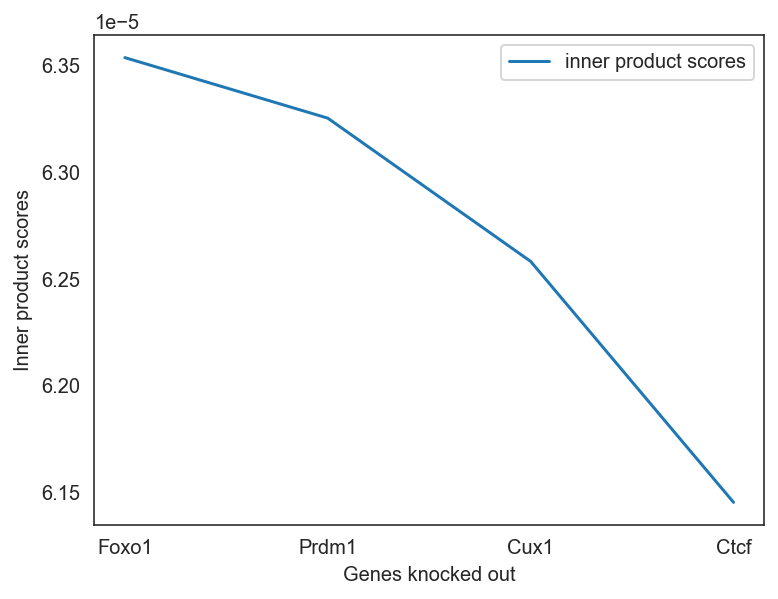

In [234]:
df = pd.DataFrame({'inner product scores': inner_product_scores}, index=gene_list)
df.plot.line()
plt.xlabel('Genes knocked out')
plt.ylabel('Inner product scores')